In [1]:
import os
import numpy as np
import math
os.environ["NUMBA_ENABLE_CUDASIM"] = "1"
from numba import jit, njit, vectorize, cuda

## Exercise 1

Create a vectorized version of log and exp math function for 1D array A = [2, 5, 10, 3, 8]

Results should be: 
+ [0.6931472 1.609438  2.3025851 1.0986123 2.0794415]
+ [7.3890562e+00 1.4841316e+02 2.2026465e+04 2.0085537e+01 2.9809580e+03]

In [2]:
from numba import vectorize, int32, float64, float32
A = np.array([2,5,10,3,8],dtype = np.int32)

@vectorize([float64(int32)], target='parallel', fastmath=True)
def log_vec(x):
    return np.log(x)

@vectorize([float64(int32)], target='parallel', fastmath=True)
def exp_vec(x):
    return np.exp(x)

print('log(A): \n',log_vec(A))
print('exp(A): \n',exp_vec(A))

log(A): 
 [0.69314718 1.60943791 2.30258509 1.09861229 2.07944154]
exp(A): 
 [7.38905610e+00 1.48413159e+02 2.20264658e+04 2.00855369e+01
 2.98095799e+03]


## Exerice 2
Compute the value of a Gaussian probability density function at $x$ with $mean = 1$, $\sigma = 1$, lower and upper bound in $(-3, 3)$ and $size = 100000$

In [3]:
from scipy.stats import norm
N = int(1e5)
x = np.linspace(-3,3,N)

@vectorize([float64(float64)], target='parallel', fastmath=True)
def Gaussian_pdf(x):
    mean = 1
    sigma = 1        
    return 1/(sigma*np.sqrt(2*np.pi))*np.exp(-1/2*(x-mean)**2/sigma**2)

result = Gaussian_pdf(x)
print(result)

[0.00013383 0.00013386 0.00013389 ... 0.05400393 0.05399745 0.05399097]


## Exercise 3

Create a "zero suppression" function. A common operation when working with waveforms is to force all samples values below a certain absolute magnitude to be zero, as a way to eliminate low amplitude noise. 
Plot the data before and after the application of the zero_suppress function.

$thresold = 15$

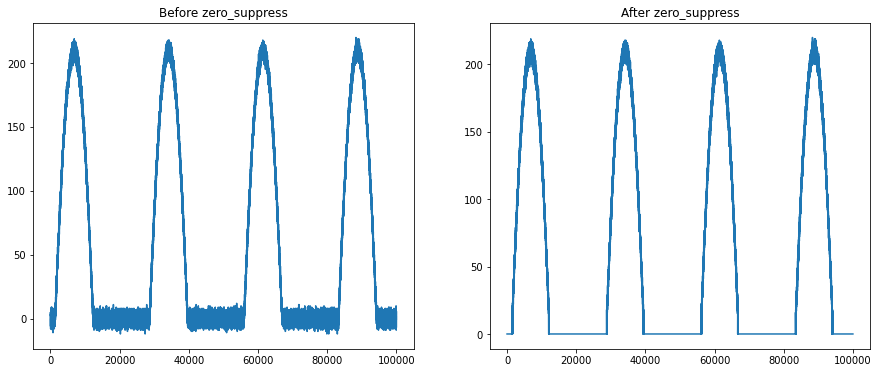

In [4]:
%matplotlib inline
from matplotlib import pyplot as plt

n = 100000
noise = np.random.normal(size=n) * 3
pulses = np.maximum(np.sin(np.arange(n) / (n / 23)) - 0.3, 0.0)
data = ((pulses * 300) + noise).astype(np.int16)
        
#put your code here
threshold = 15
@vectorize([float64(float64,int32)], target='parallel', fastmath=True)
def zero_suppress(x,thr):
    if (x < thr):
        return 0
    return x    

data_0 = zero_suppress(data,threshold)
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize=(15,6), squeeze=False)
ax[0,0].plot(data)
ax[0,0].set_title("Before zero_suppress")
ax[0,1].plot(data_0)
ax[0,1].set_title("After zero_suppress")
plt.show()

## Exercise 4

Calculate the Sigmoid kernel between the matrix X and Y defined as below. The Sigmoid kernel is defined as:

$k(x,y) = \tanh(\alpha x^T y + c) $

In [5]:
X = np.random.rand(3,3)
Y = np.random.rand(3,3)

@jit(nopython = True)
def sigmoid_kernel(a,b):
    alpha = 1
    c = 2
    return np.tanh(alpha*(a.T).dot(b)+c)

sigmoid_kernel(X,Y)

array([[0.96893617, 0.98164878, 0.98581791],
       [0.98604112, 0.99288688, 0.99087153],
       [0.9866907 , 0.99367305, 0.99429639]])

## Exercise 5

Create a kernel function similar to the ```double_kernel``` see during the lecture and create a new function that takes a 3 dimensional matrix as input calculating the $cos$ for each element and then returns the result. The shape of the matrix must be $256X256X256$. The matrix can be randomly generated

In [6]:
@cuda.jit
def double_kernel_3D(io_array):
    row, col = cuda.grid(2)
    if row < io_array.shape[0] and col < io_array.shape[1] and io_array.shape[2]:
        io_array[row][col] = np.cos(io_array[row][col]) # do the computation

# Host code   
data = np.random.randint(10,size=(256,256,256))
cuda.synchronize()
# Configure the blocks
threadsperblock = (16, 8,2) #ThreadsPerBlock must be a divisor of the data dimension: 1024/ 64 / 16 = 1
blockspergrid_x = int(math.ceil(data.shape[0] / threadsperblock[0]))
blockspergrid_y = int(math.ceil(data.shape[1] / threadsperblock[1]))
blockspergrid_z = int(math.ceil(data.shape[2] / threadsperblock[2]))
blockspergrid = (blockspergrid_x, blockspergrid_y,blockspergrid_z)


device_data = cuda.to_device(data)

double_kernel_3D[blockspergrid, threadsperblock](device_data)
cuda.synchronize()
print(device_data.copy_to_host())

[[[1 1 1 ... 1 1 1]
  [1 1 1 ... 1 1 1]
  [1 1 1 ... 1 1 1]
  ...
  [0 1 1 ... 1 1 1]
  [1 1 1 ... 1 1 1]
  [1 1 1 ... 1 1 1]]

 [[1 1 1 ... 1 1 1]
  [1 1 1 ... 1 1 1]
  [1 0 1 ... 0 1 1]
  ...
  [1 1 0 ... 0 1 1]
  [1 1 1 ... 1 1 1]
  [1 0 1 ... 1 1 1]]

 [[1 1 1 ... 1 1 1]
  [1 1 1 ... 1 1 1]
  [1 1 1 ... 1 1 1]
  ...
  [1 1 1 ... 1 1 1]
  [1 1 1 ... 1 1 1]
  [1 1 1 ... 1 1 1]]

 ...

 [[1 1 1 ... 1 1 1]
  [1 1 1 ... 1 1 1]
  [1 1 1 ... 1 1 1]
  ...
  [1 1 1 ... 1 1 1]
  [1 1 1 ... 1 1 1]
  [1 1 1 ... 1 1 1]]

 [[1 1 1 ... 1 1 0]
  [1 0 1 ... 1 1 1]
  [1 1 1 ... 1 0 1]
  ...
  [1 1 1 ... 0 1 1]
  [1 1 0 ... 1 1 1]
  [1 1 0 ... 1 1 1]]

 [[0 1 1 ... 1 1 1]
  [1 1 1 ... 1 1 1]
  [1 1 1 ... 1 1 1]
  ...
  [1 1 1 ... 1 1 1]
  [0 1 1 ... 1 0 1]
  [1 1 0 ... 1 1 0]]]


## Exercise 6

Create a matrix multiplication kernel function, called ```matmul``` that takes as input two 2D matrices:
+ A of shape $24x12$
+ B of shape $12x22$
and that computes the multiplication and put the results into a third matrix C of shape $24x12$

A and B must be randomly generated and only int values are allowed.


In [7]:
from __future__ import division
from numba import cuda
import numpy
import math

# complete the code
@cuda.jit
def matmul(A, B, C):
    """Perform matrix multiplication of C = A * B
    """
    row, col = cuda.grid(2)
    if row < C.shape[0] and col < C.shape[1]:
        tmp = 0.
        for k in range(A.shape[1]):
            tmp += A[row, k] * B[k, col]
        C[row, col] = tmp

# Initialize the data arrays
A = np.random.randint(1000, size = (24, 12))
B = np.random.randint(1000, size = (12, 22))

# Configure the blocks
threadsperblock = (8, 4)
blockspergrid_x = int(math.ceil(A.shape[0] / threadsperblock[0]))
blockspergrid_y = int(math.ceil(B.shape[1] / threadsperblock[1]))
blockspergrid = (blockspergrid_x, blockspergrid_y)

# Copy the arrays to the device
A_global_mem = cuda.to_device(A)
B_global_mem = cuda.to_device(B)

# Allocate memory on the device for the result
C_global_mem = cuda.device_array((24, 12))

# Start the kernel 
matmul[blockspergrid, threadsperblock](A_global_mem, B_global_mem, C_global_mem)

print(C_global_mem.copy_to_host())

[[2507809. 3196050. 2769664. 2909967. 2006331. 3569202. 3215371. 2889393.
  2788680. 3112182. 2970539. 2567820.]
 [2668923. 2569224. 2457383. 2737331. 2131116. 3144889. 2520638. 2256426.
  1931544. 2892508. 3089828. 1948745.]
 [3445146. 3865519. 3211999. 3685467. 2589402. 4421774. 3446694. 3944462.
  3080686. 4266893. 3521029. 2732658.]
 [3258164. 3839828. 2593455. 3354923. 2547109. 4002671. 2550508. 3400607.
  2480020. 4111575. 3491146. 1849304.]
 [3381619. 3894991. 2823288. 3328404. 2936849. 4432694. 3495550. 3245296.
  3289746. 3896750. 3566602. 2687915.]
 [3088316. 2982809. 1971607. 2860186. 2303651. 3543254. 2392325. 2210979.
  2608640. 3259952. 3017958. 1864655.]
 [5150392. 5096404. 4272743. 5067738. 3798400. 5952465. 4651729. 3830382.
  4295063. 5251615. 4834612. 3628638.]
 [4032678. 4218608. 3879997. 4375583. 2669130. 5119096. 4004903. 3963166.
  3214540. 4693623. 3900996. 2627754.]
 [3524676. 4431018. 2882789. 3901824. 2905302. 5209234. 3774497. 3699829.
  3383623. 4532660. 40